In [22]:
import pandas as pd
import re 
import random

from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pickle

# Sources: 
# https://nbviewer.org/github/dpanagop/ML_and_AI_examples/blob/master/NLP_example_clustering.ipynb
# https://towardsdatascience.com/clustering-documents-with-python-97314ad6a78d
# https://www.analyticsvidhya.com/blog/2019/09/introduction-information-extraction-python-spacy/?utm_source=blog&utm_medium=nlp-project-information-extraction


df = pd.read_csv('data/mit_dataset/interview_transcripts_by_turkers.csv', names=['Type', 'Transcript'])

In [23]:
dicto = {"Polling Assistant": """Work on polling day from 7am to 11pm.
• Possibly be asked to work part-time to assist with peak periods, including five-hour shifts.
• Need to complete online training before polling day.
• Be working with small groups of diverse people, so the ability to work effectively as part of a
team is important.
• Possibly be working under pressure in a fast-moving operational environment.
• Possibly have long periods of sitting or standing and may need to lift and carry up to 12
kilograms.""",
"Scrutiny Assistant": """Work on polling day from approximately 5pm until 11pm.
• Need to complete online training before polling day.
• Be working with small groups of diverse people, so the ability to work effectively as
part of a team is important.
• Work non-standard or extended hours under pressure in a fast-moving operational
environment.
• Possibly have long periods of sitting and standing and need ability to lift and carry up
to 12 kilograms.""",
"Electoral visitor": """Be required to work over the early voting period on a roster.
• Need to complete online and face-to-face training before polling day.
• Be required to travel to one facility per day.
• Work non-standard or extended hours under pressure in a fast-moving operational
environment.
• Take ownership and responsibility for own work.
• Handle ballot papers safely and securely throughout all electoral processes.
• Possibly have long periods sitting, standing or driving, and require the ability to lift and carry
up to 15 kilograms of materials. Polling materials must be packed and unpacked at each
location and can be considerable.
• Be working with small groups of diverse people, so the ability to work effectively as part of a
team is important.""",
"Polling Place Officer in Charge": """Work on polling day from 7am to 11pm.
• Supervise 3 to 20 staff depending on the size of the polling place.
• Require the use of a private motor vehicle to collect polling material and in some cases
return material as instructed.
• Need to complete online and face-to-face training before polling day.
Working at an election – Polling Place Officer in Charge EO4-EO5
The terms and conditions for temporary staff employed by the AEC during federal elections, by-elections,
plebiscites and referendums are set out in the Collective Determination, which includes all remuneration
information, including casual loading, overtime, allowances and payment for required training.
• Be working with small groups of diverse people, so the ability to work effectively as
part of a team is important.
• Work non-standard or extended hours under pressure in a fast-moving operational
environment. You may need to undertake some work before polling day.
• Possibly have long periods of sitting or standing and require the ability to lift and carry
up to 12 kilograms.
• Need to be able to communicate clearly and have good attention to detail.
• Need the ability to remain calm under pressure and build rapport, while remaining
professional, confident, and decisive.
• Take ownership and responsibility for own work.
• Handle ballot papers safely and securely throughout all electoral processes."""}

keys = dicto.keys()
aec = [dicto[x].replace("• ", '').replace("\n", ' ').lower() for x in keys]

# print(aec)

In [24]:
## Grab only the pre interviews:

df = df.loc[~df['Type'].str.contains("pp")]
df['Interviewee'] = ''

## Split transcript to remove interviewer

# df = df[:10]

for index, row in df.iterrows():

    ## Randomly append the job descriptions
    indexes = [0,1,2,3]
    rando = random.choice(indexes)
    chosen = aec[rando]

    transcript = row['Transcript']
    transcript = transcript.split("|")
    transcript = [x for x in transcript if "Interviewer" not in x]

    activities = [x for x in transcript if "activities" in x.lower()]
    interests = [x for x in transcript if "interest" in x.lower()]

    interviewee = " ".join(transcript)
    interviewee = interviewee.replace('Interviewee:', '')

    row['Interviewee'] = interviewee + " " + chosen


In [25]:
## Create a vector

interviewees = df['Interviewee'].tolist()
# transcripts = df['Transcript'].tolist()

vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(df['Interviewee'])
# X = vectorizer.fit_transform(df['Transcript'])

Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

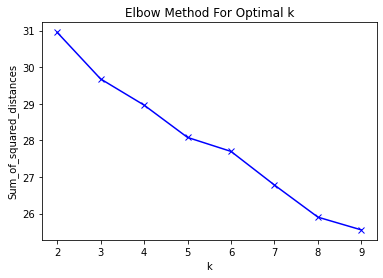

In [26]:
### Find the elbow

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [27]:
true_k = 4
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)
labels=model.labels_
# wiki_cl=pd.DataFrame(list(labels),columns=['title','cluster'])
# print(wiki_cl.sort_values(by=['cluster']))

pickle.dump(model, open('data/models/first_knn.sav', 'wb'))

# print(labels)

Cluster: 0


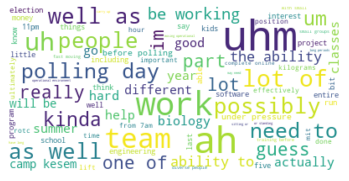

Cluster: 1


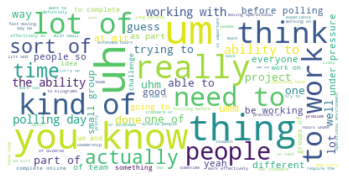

Cluster: 2


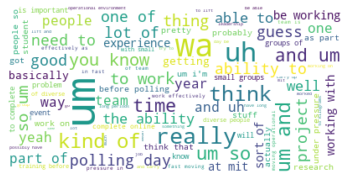

Cluster: 3


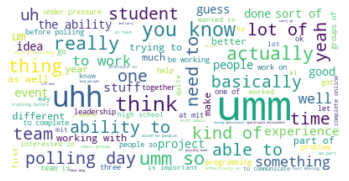

In [28]:
from wordcloud import WordCloud 
result={'cluster':labels,'wiki': interviewees} 
# result={'cluster':labels,'wiki': transcripts} 
result=pd.DataFrame(result) 
for k in range(0,true_k): 
   s=result[result.cluster==k] 
   text=s['wiki'].str.cat(sep=' ') 
   text=text.lower() 
   text=' '.join([word for word in text.split()]) 
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text) 
   print('Cluster: {}'.format(k)) 
#    print('Titles') 
#    titles=wiki_cl[wiki_cl.cluster==k]['title']          
#    print(titles.to_string(index=False)) 
   plt.figure() 
   plt.imshow(wordcloud, interpolation="bilinear") 
   plt.axis("off") 
   plt.show()

In [35]:
### Prediction test
from peewee import *
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

chooser = pickle.load(open('data/models/first_knn.sav', 'rb'))

db = SqliteDatabase('responses.db')

class Response(Model):

    firstName = CharField()
    lastName = CharField()

    postcode = CharField()
    lift12kgs = BooleanField()
    license = BooleanField()

    email = CharField()
    link = CharField()

    time = DateTimeField()

    transcript = TextField()
    prediction = CharField()

    class Meta:
        database = db

db.connect()

for story in Response.select().where(Response.license == False):
    texto = vectorizer.transform([story.transcript])
    # texto = story.transcript
    prediction = chooser.predict(texto)
    # print(texto)
    print("hi")
    print(prediction)
    print('hi')
    # prediction = dicto[prediction[0]]
    # print(story.transcript)

hi
[1]
hi
